In [1]:
#!pip install xgboost
#!pip install keras
#!pip install lightgbm

In [2]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling  import RandomUnderSampler,AllKNN,NearMiss, TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
import lightgbm as lgb
from lightgbm import LGBMClassifier
import nltk
#nltk.download('all')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import joblib
from imblearn.metrics import classification_report_imbalanced
from collections import Counter
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
df = pd.read_excel('final.xlsx')

In [ ]:
#defining a new column which will serve as label to classify the reviews
def label_classify(compound):
    if compound>0:
        return 'positive'
    elif compound<=0:
        return 'negative'

df['label']= df['compound'].apply(label_classify) 

In [5]:
df.drop(columns=['Unnamed: 0','neg','neu','pos','compound','Rating','Review_Length'],inplace=True)
df.rename({'Review':'review','label':'sentiment'},axis=1,inplace=True)

In [6]:
df

,review,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,positive
2,nice rooms not 4* experience hotel monaco seat...,positive
3,"unique, great stay, wonderful time hotel monac...",positive
4,"great stay great stay, went seahawk game aweso...",positive
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",positive
20487,great location price view hotel great quick pl...,positive
20488,"ok just looks nice modern outside, desk staff ...",positive
20489,hotel theft ruined vacation hotel opened sept ...,positive


In [7]:
def preprocess_data(data):
    # Convert text to lowercase
    data['review'] = data['review'].str.strip().str.lower()
    return data

df = preprocess_data(df)

# <span style="color:red">MODEL BUILDING

In [8]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'].values, test_size=0.30)

In [9]:
#Tfidf Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
#Vectorizing the X_train
X_train_tf = vectorizer.transform(X_train)
X_train_tf = X_train_tf.toarray()
#Vectorizing the X_test
X_test_tf = vectorizer.transform(X_test)
X_test_tf = X_test_tf.toarray()

## <span style="color:TEAL">NAIVE BAYES

In [10]:
#Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train_tf, y_train)
y_preds_mnb = mnb.predict(X_test_tf)

In [11]:
#printing accuracy score and classification report
print(accuracy_score(y_test, y_preds_mnb))
print(classification_report(y_test, y_preds_mnb))

0.9209499024072869
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       486
    positive       0.92      1.00      0.96      5662

    accuracy                           0.92      6148
   macro avg       0.46      0.50      0.48      6148
weighted avg       0.85      0.92      0.88      6148



In [12]:
#predicting on new review (negative)
mnb.predict(vectorizer.transform(['hate this hotel simply awful!']).toarray())

array(['positive'], dtype='<U8')

In [13]:
#predicting on new review (positive)
mnb.predict(vectorizer.transform(['Love this hotel simply awesome!']).toarray())

array(['positive'], dtype='<U8')

In [79]:
#predicting on new review (positive)
mnb.predict(vectorizer.transform(["I recently had the pleasure of staying at this hotel, and it exceeded all of my expectations! From the moment I arrived, I was greeted with warm smiles and exceptional hospitality from the staff. The room was immaculate, spacious, and tastefully decorated, providing a cozy and inviting atmosphere. The bed was incredibly comfortable, ensuring a restful night's sleep. The hotel's amenities, including the pool and fitness center, were top-notch and well-maintained. The location was fantastic, conveniently close to restaurants, shops, and attractions. Overall, my experience was nothing short of outstanding, and I can't wait to return for another memorable stay!"]).toarray())

array(['positive'], dtype='<U8')

In [80]:
#predicting on new review (negative)
mnb.predict(vectorizer.transform(["My stay at this hotel was a complete disappointment. The room was dirty and poorly maintained, with peeling wallpaper and musty odors. The bathroom was in dire need of renovation, with cracked tiles and mold in the shower. Despite requesting a non-smoking room, I could still smell cigarette smoke, making the experience unpleasant. The staff were unhelpful and seemed disinterested in addressing my complaints. Overall, I regret staying at this hotel and would not consider returning in the future."]).toarray())

array(['positive'], dtype='<U8')

**<span style="color:blue">OVERSAMPLING / UNDERSAMPLING**

In [14]:
#user-defined method to check accuracy with different sampling techniques
def run_model(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    print(Counter(y_train))
    
    vectorizer_smote = TfidfVectorizer()
    vectorizer_smote.fit(X_train)
    X_train_vec = vectorizer_smote.transform(X_train)
    X_train_vec = X_train_vec.toarray()
    X_test_vec = vectorizer_smote.transform(X_test)
    X_test_vec = X_test_vec.toarray()
    
    oversample = model
    X_train_over, y_train_over = oversample.fit_resample(X_train_vec, y_train)
    print(Counter(y_train_over))
    
    nb = GaussianNB()
    nb.fit(X_train_over, y_train_over)
    y_preds = nb.predict(X_test_vec)
    score = accuracy_score(y_test,y_preds)
    print("Accuracy: ",score)
    return score

X=df['review']
y= df['sentiment'].values

In [15]:
#Over-sampling by Adaptive Synthetic Sampling method
oversample = ADASYN()
ov1=run_model(X,y,model=oversample)

Counter({'positive': 13207, 'negative': 1136})
Counter({'positive': 13207, 'negative': 13183})
Accuracy:  0.8292127521145087


In [16]:
#Over-sampling by Borderline SMOTE method
oversample=BorderlineSMOTE()
ov2=run_model(X,y,model=oversample)

Counter({'positive': 13220, 'negative': 1123})
Counter({'positive': 13220, 'negative': 13220})
Accuracy:  0.8305139882888745


In [17]:
#Over-sampling by RandomOverSampler method
oversample= RandomOverSampler()
ov3=run_model(X,y,model=oversample)

Counter({'positive': 13203, 'negative': 1140})
Counter({'positive': 13203, 'negative': 13203})
Accuracy:  0.8293754066363045


In [18]:
#Over-sampling by RandomUnderSampler method
undersample=RandomUnderSampler()
un1=run_model(X,y,model=undersample)

Counter({'positive': 13186, 'negative': 1157})
Counter({'negative': 1157, 'positive': 1157})
Accuracy:  0.6751789199739753


In [19]:
#Under-sampling by All K-Nearest Neighbours method.
undersample=AllKNN()
un2=run_model(X,y,model=undersample)

Counter({'positive': 13161, 'negative': 1182})
Counter({'positive': 11468, 'negative': 1182})
Accuracy:  0.8266102797657775


In [20]:
#Under-sampling by NearMiss method
undersample=NearMiss(version=1)
un3=run_model(X,y,model=undersample)

Counter({'positive': 13200, 'negative': 1143})
Counter({'negative': 1143, 'positive': 1143})
Accuracy:  0.6278464541314248


In [21]:
#Under-sampling by removing Tomek's links.
undersample=TomekLinks()
un4=run_model(X,y,model=undersample)

Counter({'positive': 13206, 'negative': 1137})
Counter({'positive': 13086, 'negative': 1137})
Accuracy:  0.8376707872478855


In [59]:
#dataframe displays the various sampling methods and their accuracies
sample = pd.DataFrame({'Method':['ADASYN','BorderlineSMOTE','RandomOverSampler','RandomUnderSampler',
                                 'AllKNN','NearMiss','TomekLinks'],
                      'Accuracy':[ov1,ov2,ov3,un1,un2,un3,un4]})
sample

,Method,Accuracy
0,ADASYN,0.829213
1,BorderlineSMOTE,0.830514
2,RandomOverSampler,0.829375
3,RandomUnderSampler,0.675179
4,AllKNN,0.826610
5,NearMiss,0.627846
6,TomekLinks,0.837671


<Axes: xlabel='Accuracy', ylabel='Method'>

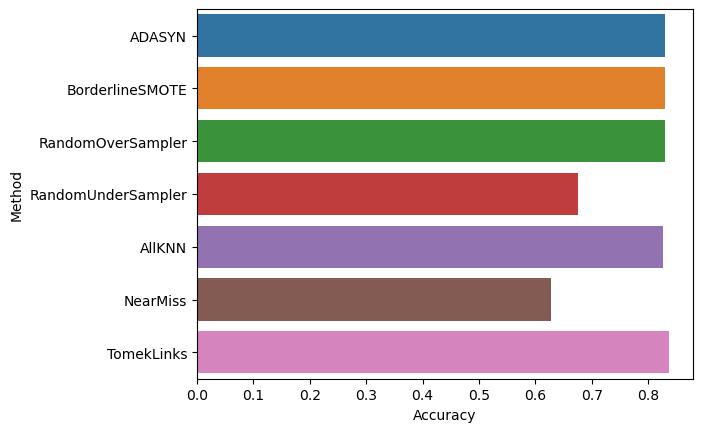

In [60]:
#plotting the sampling methods and their accuracies
sns.barplot(data=sample,x='Accuracy',y='Method')

In [23]:
#RandomOverSampling is chosen to balance the imabalanced data
ROS = RandomOverSampler()
X_train_ros, y_train_ros = ROS.fit_resample(X_train_tf, y_train)

## <span style="color:TEAL">LOGISTIC REGRESSION

In [24]:
#Logistic Regression
logisticReg = LogisticRegression()
logisticReg.fit(X_train_ros, y_train_ros)
y_preds_lr = logisticReg.predict(X_test_tf)

In [113]:
#printing accuracy score and classification report of test data
lr = accuracy_score(y_test, y_preds_lr)
print('Accuracy:',lr)
print(classification_report(y_test, y_preds_lr))

Accuracy: 0.9276187378009109
              precision    recall  f1-score   support

    negative       0.53      0.83      0.64       486
    positive       0.98      0.94      0.96      5662

    accuracy                           0.93      6148
   macro avg       0.76      0.88      0.80      6148
weighted avg       0.95      0.93      0.93      6148



In [114]:
#printing accuracy score of train data
y_preds_lrt = logisticReg.predict(X_train_tf)
lrt = accuracy_score(y_train, y_preds_lrt)
print('Accuracy:',lrt)

Accuracy: 0.9552394896465175


In [26]:
#predicting on new review (negative)
logisticReg.predict(vectorizer.transform(['hate this hotel simply awful!']).toarray())

array(['negative'], dtype=object)

In [27]:
#predicting on new review (positive)
logisticReg.predict(vectorizer.transform(['Love this hotel simply awesome!']).toarray())

array(['positive'], dtype=object)

In [81]:
#predicting on new review (negative)
logisticReg.predict(vectorizer.transform(["My stay at this hotel was a complete disappointment. The room was dirty and poorly maintained, with peeling wallpaper and musty odors. The bathroom was in dire need of renovation, with cracked tiles and mold in the shower. Despite requesting a non-smoking room, I could still smell cigarette smoke, making the experience unpleasant. The staff were unhelpful and seemed disinterested in addressing my complaints. Overall, I regret staying at this hotel and would not consider returning in the future."]).toarray())

array(['negative'], dtype=object)

In [82]:
#predicting on new review (positive)
logisticReg.predict(vectorizer.transform(["I recently had the pleasure of staying at this hotel, and it exceeded all of my expectations! From the moment I arrived, I was greeted with warm smiles and exceptional hospitality from the staff. The room was immaculate, spacious, and tastefully decorated, providing a cozy and inviting atmosphere. The bed was incredibly comfortable, ensuring a restful night's sleep. The hotel's amenities, including the pool and fitness center, were top-notch and well-maintained. The location was fantastic, conveniently close to restaurants, shops, and attractions. Overall, my experience was nothing short of outstanding, and I can't wait to return for another memorable stay!"]).toarray())

array(['positive'], dtype=object)

## <span style="color:TEAL">RANDOM FOREST

In [28]:
#Random Forest 
rf = RandomForestClassifier()
rf.fit(X_train_ros, y_train_ros)
y_preds_rf = rf.predict(X_test_tf)

In [29]:
#printing accuracy score and classification report on test data
rf_acc = accuracy_score(y_test, y_preds_rf)
print('Accuracy:',rf_acc)
print(classification_report(y_test, y_preds_rf))

0.930871828236825
              precision    recall  f1-score   support

    negative       0.78      0.17      0.29       486
    positive       0.93      1.00      0.96      5662

    accuracy                           0.93      6148
   macro avg       0.86      0.59      0.62      6148
weighted avg       0.92      0.93      0.91      6148



In [95]:
#printing accuracy score of train data
y_preds_rft = rf.predict(X_train_tf)
rf_acc_t = accuracy_score(y_train, y_preds_rft)
print('Accuracy:',rf_acc_t)

Accuracy Score: 1.0


In [96]:
#hyper-parameter tuning for Random Forest 
#estimator_rf = RandomForestClassifier()
#param_rf = [{'max_depth': [2,None],'min_samples_leaf': [2,5],'n_estimators': [100,300],'max_depth':[10,50],'min_samples_split':[2,10]}]
#rf_random = RandomizedSearchCV(estimator = estimator_rf, param_distributions = param_rf, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
#rf_random.fit(X_train_ros, y_train_ros)

In [30]:
#predicting on new review (negative)
rf.predict(vectorizer.transform(['hate this hotel simply awful!']).toarray())

array(['negative'], dtype=object)

In [31]:
#predicting on new review (positive)
rf.predict(vectorizer.transform(['Love this hotel simply awesome!']).toarray())

array(['positive'], dtype=object)

In [83]:
#predicting on new review (negative)
rf.predict(vectorizer.transform(["My stay at this hotel was a complete disappointment. The room was dirty and poorly maintained, with peeling wallpaper and musty odors. The bathroom was in dire need of renovation, with cracked tiles and mold in the shower. Despite requesting a non-smoking room, I could still smell cigarette smoke, making the experience unpleasant. The staff were unhelpful and seemed disinterested in addressing my complaints. Overall, I regret staying at this hotel and would not consider returning in the future."]).toarray())

array(['negative'], dtype=object)

In [84]:
#predicting on new review (positive)
rf.predict(vectorizer.transform(["I recently had the pleasure of staying at this hotel, and it exceeded all of my expectations! From the moment I arrived, I was greeted with warm smiles and exceptional hospitality from the staff. The room was immaculate, spacious, and tastefully decorated, providing a cozy and inviting atmosphere. The bed was incredibly comfortable, ensuring a restful night's sleep. The hotel's amenities, including the pool and fitness center, were top-notch and well-maintained. The location was fantastic, conveniently close to restaurants, shops, and attractions. Overall, my experience was nothing short of outstanding, and I can't wait to return for another memorable stay!"]).toarray())

array(['positive'], dtype=object)

## <span style="color:TEAL">LIGHT GRADIENT BOOSTING MACHINE (LGBM)

In [75]:
#LGBM
lgbm = LGBMClassifier()
lgbm.fit(X_train_ros, y_train_ros)
y_preds_lgbm = lgbm.predict(X_test_tf)

[LightGBM] [Info] Number of positive: 13200, number of negative: 13200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.969855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335646
[LightGBM] [Info] Number of data points in the train set: 26400, number of used features: 7906
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [111]:
#printing accuracy score and classification report of test data
lg = accuracy_score(y_test, y_preds_lgbm)
print('Accuaracy:',lg)
print(classification_report(y_test, y_preds_lgbm))

Accuaracy: 0.930871828236825
              precision    recall  f1-score   support

    negative       0.55      0.75      0.63       486
    positive       0.98      0.95      0.96      5662

    accuracy                           0.93      6148
   macro avg       0.76      0.85      0.80      6148
weighted avg       0.94      0.93      0.94      6148



In [97]:
#printing accuracy score of train data
y_preds_lgt = lgbm.predict(X_train_tf)
lgt = accuracy_score(y_train, y_preds_lgt)
print('Accuracy:',lgt)

Accuracy Score: 0.977061981454368


In [77]:
#hyper-parameter tuning for LGBM
#param_grid = {'num_leaves': [5, 20],'learning_rate': [0.05, 0.2],'n_estimators': [50, 100]}
#lgb_classifier = lgb.LGBMClassifier(objective='binary', num_class=1)
#rcv = RandomizedSearchCV(estimator=lgb_classifier, param_distributions=param_grid,scoring='accuracy', cv=2)
#rcv.fit(X_train_ros, y_train_ros)
#print("Best Parameters:",rcv.best_params_)
#print("Best Score:",rcv.best_score_)

In [34]:
#predicting on new review (negative)
lgbm.predict(vectorizer.transform(['hate this hotel simply awful!']).toarray())

array(['negative'], dtype=object)

In [35]:
#predicting on new review (positive)
lgbm.predict(vectorizer.transform(['Love this hotel simply awesome!']).toarray())

array(['positive'], dtype=object)

In [85]:
#predicting on new review (negative)
lgbm.predict(vectorizer.transform(["My stay at this hotel was a complete disappointment. The room was dirty and poorly maintained, with peeling wallpaper and musty odors. The bathroom was in dire need of renovation, with cracked tiles and mold in the shower. Despite requesting a non-smoking room, I could still smell cigarette smoke, making the experience unpleasant. The staff were unhelpful and seemed disinterested in addressing my complaints. Overall, I regret staying at this hotel and would not consider returning in the future."]).toarray())

array(['negative'], dtype=object)

In [86]:
#predicting on new review (positive)
lgbm.predict(vectorizer.transform(["I recently had the pleasure of staying at this hotel, and it exceeded all of my expectations! From the moment I arrived, I was greeted with warm smiles and exceptional hospitality from the staff. The room was immaculate, spacious, and tastefully decorated, providing a cozy and inviting atmosphere. The bed was incredibly comfortable, ensuring a restful night's sleep. The hotel's amenities, including the pool and fitness center, were top-notch and well-maintained. The location was fantastic, conveniently close to restaurants, shops, and attractions. Overall, my experience was nothing short of outstanding, and I can't wait to return for another memorable stay!"]).toarray())

array(['positive'], dtype=object)

## <span style="color:TEAL">EXTREME GRADIENT BOOSTING (XGBOOST)

In [100]:
#Label Encoding on the 'sentiment' label (0:negative, 1:positive)
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])

X_tr, X_te, y_tr, y_te = train_test_split(df['review'], df['sentiment'].values, test_size=0.30)
vec = TfidfVectorizer()
vec.fit(X_tr)
X_tr_tf = vec.transform(X_tr)
X_tr_tf = X_tr_tf.toarray()
X_te_tf = vec.transform(X_te)
X_te_tf = X_te_tf.toarray()

r = RandomOverSampler()
X_tr_ros, y_tr_ros = r.fit_resample(X_tr_tf, y_tr)

In [101]:
#XGBoost
xgb = XGBClassifier()
xgb.fit(X_tr_ros, y_tr_ros)
y_preds_xgb = xgb.predict(X_te_tf)

In [102]:
#printing accuracy score and classification report of test data
xg = accuracy_score(y_te, y_preds_xgb)
print('Accuracy:',xg)
print(classification_report(y_te, y_preds_xgb))

Accuracy: 0.936890045543266
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       479
           1       0.97      0.96      0.97      5669

    accuracy                           0.94      6148
   macro avg       0.78      0.81      0.79      6148
weighted avg       0.94      0.94      0.94      6148



In [103]:
#printing accuracy score of train data
y_preds_xgt = xgb.predict(X_tr_tf)
xgt = accuracy_score(y_tr, y_preds_xgt)
print('Accuracy:',xgt)

Accuracy: 0.9854284319877292


In [104]:
#hyper-parameter tuning for XGBoost
#param_dist = {'max_depth': [3,10],'learning_rate': [0.01,0.1],'n_estimators':[50,100]}
#xgb_model = XGBClassifier()
#random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=2, scoring='accuracy')
#random_search.fit(X_tr_ros, y_tr_ros)
#print("Best set of hyperparameters: ", random_search.best_params_)
#print("Best score: ", random_search.best_score_)

In [105]:
#predicting on new review (negative)
xgb.predict(vec.transform(['hate this hotel simply awful!']).toarray())

array([0])

In [106]:
#predicting on new review (positive)
xgb.predict(vec.transform(['Love this hotel simply awesome!']).toarray())

array([1])

In [107]:
#predicting on new review (negative)
xgb.predict(vec.transform(["My stay at this hotel was a complete disappointment. The room was dirty and poorly maintained, with peeling wallpaper and musty odors. The bathroom was in dire need of renovation, with cracked tiles and mold in the shower. Despite requesting a non-smoking room, I could still smell cigarette smoke, making the experience unpleasant. The staff were unhelpful and seemed disinterested in addressing my complaints. Overall, I regret staying at this hotel and would not consider returning in the future."]).toarray())

array([0])

In [108]:
#predicting on new review (positive)
xgb.predict(vec.transform(["I recently had the pleasure of staying at this hotel, and it exceeded all of my expectations! From the moment I arrived, I was greeted with warm smiles and exceptional hospitality from the staff. The room was immaculate, spacious, and tastefully decorated, providing a cozy and inviting atmosphere. The bed was incredibly comfortable, ensuring a restful night's sleep. The hotel's amenities, including the pool and fitness center, were top-notch and well-maintained. The location was fantastic, conveniently close to restaurants, shops, and attractions. Overall, my experience was nothing short of outstanding, and I can't wait to return for another memorable stay!"]).toarray())

array([1])

## <span style="color:TEAL">NAIVE BAYES

In [42]:
#Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_ros, y_train_ros)
y_preds_nb = nb.predict(X_test_tf)

In [112]:
#printing accuracy score and classification report
nb_acc = accuracy_score(y_test, y_preds_nb)
print('Accuracy:',nb_acc)
print(classification_report(y_test, y_preds_nb))

Accuracy: 0.9056603773584906
              precision    recall  f1-score   support

    negative       0.45      0.81      0.58       486
    positive       0.98      0.91      0.95      5662

    accuracy                           0.91      6148
   macro avg       0.71      0.86      0.76      6148
weighted avg       0.94      0.91      0.92      6148



In [118]:
#printing accuracy score of train data
y_preds_nbt = nb.predict(X_train_tf)
nbt = accuracy_score(y_train, y_preds_nbt)
print('Accuracy:',nbt)

Accuracy: 0.9270724395175347


In [44]:
#predicting on new review (negative)
nb.predict(vectorizer.transform(['hate this hotel simply awful!']).toarray())

array(['negative'], dtype='<U8')

In [45]:
#predicting on new review (positive)
nb.predict(vectorizer.transform(['Love this hotel simply awesome!']).toarray())

array(['positive'], dtype='<U8')

In [91]:
#predicting on new review (negative)
nb.predict(vectorizer.transform(["My stay at this hotel was a complete disappointment. The room was dirty and poorly maintained, with peeling wallpaper and musty odors. The bathroom was in dire need of renovation, with cracked tiles and mold in the shower. Despite requesting a non-smoking room, I could still smell cigarette smoke, making the experience unpleasant. The staff were unhelpful and seemed disinterested in addressing my complaints. Overall, I regret staying at this hotel and would not consider returning in the future."]).toarray())

array(['negative'], dtype='<U8')

In [92]:
#predicting on new review (positive)
nb.predict(vectorizer.transform(["I recently had the pleasure of staying at this hotel, and it exceeded all of my expectations! From the moment I arrived, I was greeted with warm smiles and exceptional hospitality from the staff. The room was immaculate, spacious, and tastefully decorated, providing a cozy and inviting atmosphere. The bed was incredibly comfortable, ensuring a restful night's sleep. The hotel's amenities, including the pool and fitness center, were top-notch and well-maintained. The location was fantastic, conveniently close to restaurants, shops, and attractions. Overall, my experience was nothing short of outstanding, and I can't wait to return for another memorable stay!"]).toarray())

array(['positive'], dtype='<U8')

## <span style="color:TEAL">LONG SHORT TERM MEMORY (LSTM)

In [50]:
texts = df['review']
labels = df['sentiment']

#hyperparameters
max_words = 10000 
max_len = 100 
embedding_dim = 100 
lstm_units = 64 
num_classes = 2

#tokenize the texts then create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

#pad the sequences so they all have the same length
x = pad_sequences(sequences, maxlen=max_len)
#create one-hot encoded labels
y = keras.utils.to_categorical(labels, num_classes)

#LSTM model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(2, activation='softmax'))

#compiling and fitting the model 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x, y, batch_size=32, epochs=10)

Epoch 1/10
641/641 [==============================] - 31s 45ms/step - loss: 0.2061 - accuracy: 0.9260
Epoch 2/10
641/641 [==============================] - 28s 44ms/step - loss: 0.1139 - accuracy: 0.9580
Epoch 3/10
641/641 [==============================] - 31s 48ms/step - loss: 0.0701 - accuracy: 0.9761
Epoch 4/10
641/641 [==============================] - 32s 50ms/step - loss: 0.0411 - accuracy: 0.9863
Epoch 5/10
641/641 [==============================] - 32s 50ms/step - loss: 0.0250 - accuracy: 0.9929
Epoch 6/10
641/641 [==============================] - 32s 50ms/step - loss: 0.0154 - accuracy: 0.9954
Epoch 7/10
641/641 [==============================] - 7745s 12s/step - loss: 0.0118 - accuracy: 0.9967
Epoch 8/10
641/641 [==============================] - 74s 116ms/step - loss: 0.0093 - accuracy: 0.9972
Epoch 9/10
641/641 [==============================] - 67s 104ms/step - loss: 0.0074 - accuracy: 0.9982
Epoch 10/10
641/641 [==============================] - 84s 131ms/step - loss: 0

In [51]:
#printing the loss and accuracy of the model
loss, accuracy = model.evaluate(x, y)
print("Loss:", loss)
print("Accuracy:", accuracy)

641/641 [==============================] - 36s 51ms/step - loss: 0.0043 - accuracy: 0.9987
Loss: 0.004348233342170715
Accuracy: 0.9986823201179504


In [52]:
#predicting on new review (negative)
input_text = ['hate this hotel simply awful!']
sequences = tokenizer.texts_to_sequences(input_text)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
sentiment_classes = {0: 'Negative', 1: 'Positive'}
predicted_sentiment = sentiment_classes[predicted_labels[0]]
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 3s 3s/step
Predicted Sentiment: Negative


In [53]:
#predicting on new review (positive)
input_text = ["lovely stay at this hotel"]
sequences = tokenizer.texts_to_sequences(input_text)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
sentiment_classes = {0: 'Negative', 1: 'Positive'}
predicted_sentiment = sentiment_classes[predicted_labels[0]]
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 271ms/step
Predicted Sentiment: Positive


In [109]:
#predicting on new review (negative)
input_text = ["My stay at this hotel was a complete disappointment. The room was dirty and poorly maintained, with peeling wallpaper and musty odors. The bathroom was in dire need of renovation, with cracked tiles and mold in the shower. Despite requesting a non-smoking room, I could still smell cigarette smoke, making the experience unpleasant. The staff were unhelpful and seemed disinterested in addressing my complaints. Overall, I regret staying at this hotel and would not consider returning in the future."]
sequences = tokenizer.texts_to_sequences(input_text)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
sentiment_classes = {0: 'Negative', 1: 'Positive'}
predicted_sentiment = sentiment_classes[predicted_labels[0]]
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 166ms/step
Predicted Sentiment: Negative


In [110]:
#predicting on new review (positive)
input_text = ["I recently had the pleasure of staying at this hotel, and it exceeded all of my expectations! From the moment I arrived, I was greeted with warm smiles and exceptional hospitality from the staff. The room was immaculate, spacious, and tastefully decorated, providing a cozy and inviting atmosphere. The bed was incredibly comfortable, ensuring a restful night's sleep. The hotel's amenities, including the pool and fitness center, were top-notch and well-maintained. The location was fantastic, conveniently close to restaurants, shops, and attractions. Overall, my experience was nothing short of outstanding, and I can't wait to return for another memorable stay!"]
sequences = tokenizer.texts_to_sequences(input_text)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
sentiment_classes = {0: 'Negative', 1: 'Positive'}
predicted_sentiment = sentiment_classes[predicted_labels[0]]
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 36ms/step
Predicted Sentiment: Positive


**<span style="color:blue">CHOOSING THE FINAL MODEL**

In [117]:
#dataframe displaying various models and their accuracies 
acc = pd.DataFrame({'Model':['Logistic Regression','Random Forest','LGBM','XGBOOST','Naive Bayes','LSTM'],
                   'Accuracy':[lr*100,rf_acc*100, lg*100, xg*100, nb_acc*100, accuracy*100]})
acc.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy
5,LSTM,99.868232
3,XGBOOST,93.689005
1,Random Forest,93.087183
2,LGBM,93.087183
0,Logistic Regression,92.761874
4,Naive Bayes,90.566038


# <span style="color:red"> STREAMLIT DEPLOYMENT

In [120]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

filename = 'classify.sav'
pickle.dump(model, open(filename, 'wb'))